# LIVRABLE 2 - Traitement d'images (Projet LEYENDA)

Objectif : Débruiter un ensemble d’images RGB afin de les rendre plus exploitables par les algorithmes en s’appuyant sur des auto-encodeurs convolutifs.

# Partie 1 : Import des bibliothèques

Cette partie importe l’ensemble des bibliothèques nécessaires au traitement d’images, à la construction du modèle de débruitage, et à l’évaluation des performances.

TensorFlow pour l’architecture de l’auto-encodeur, OpenCV et PIL pour la gestion des images, et skimage pour le calcul du PSNR.

In [ ]:
import os
import numpy as np
import cv2
import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU,  BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path


# Partie 2 : Chargement et préparation des images

Cette partie charge les images RGB du dossier imagesL2, les redimensionne en 128×128 pixels, les convertit au format RGB (au lieu de BGR par défaut avec OpenCV), puis on les normalise sur [0, 1] 

In [303]:
img_size = 256  # plus petit que 256
image_folder = "./imagesL2"
X = []

image_paths = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

for path in tqdm(image_paths, desc="Chargement avec OpenCV (128x128)"):
    img = cv2.imread(path)  # BGR
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    X.append(img)

X = np.array(X)
print(f"[INFO] {len(X)} images chargées avec OpenCV à {img_size}x{img_size}")

Chargement avec OpenCV (128x128): 100%|██████████| 148/148 [00:00<00:00, 325.16it/s]

[INFO] 148 images chargées avec OpenCV à 256x256


# Partie 3 : Ajout de bruit gaussien

Afin d’entraîner l’auto-encodeur à débruiter les images, on génère ici une version bruitée du dataset en y ajoutant du bruit gaussien.  
On applique donc ce bruit à chaque image

Un exemple visuel est affiché juste en dessous pour comparer une image originale et sa version bruitée avev un std de 0.5

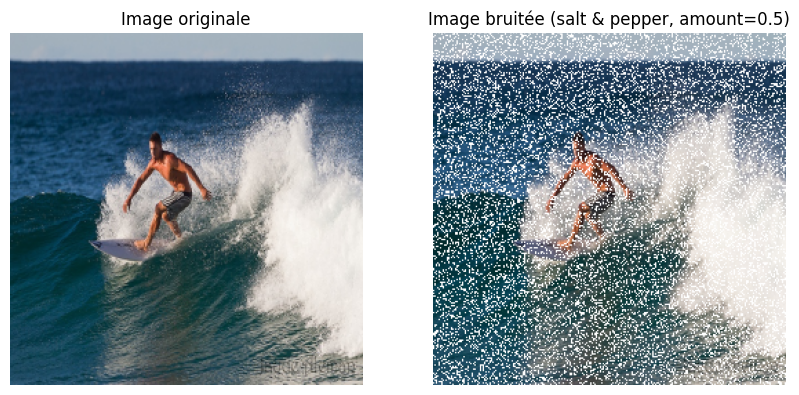

In [304]:
def add_salt_pepper_noise(images, amount=0.05, show_example=False):
    noisy_images = []

    for img in images:
        noisy_img = img.copy()
        total_pixels = img.shape[0] * img.shape[1]

        # Nombre de pixels à bruiter
        num_salt = int(amount * total_pixels / 2)
        num_pepper = int(amount * total_pixels / 2)

        # Salt (blanc)
        coords = [np.random.randint(0, i, num_salt) for i in img.shape[:2]]
        noisy_img[coords[0], coords[1]] = 1

        noisy_images.append(noisy_img)

    noisy_images = np.array(noisy_images)

    if show_example:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.title("Image originale")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(noisy_images[0])
        plt.title(f"Image bruitée (salt & pepper, amount={amount})")
        plt.axis("off")
        plt.show()

    return noisy_images

X_noisy = add_salt_pepper_noise(X, amount=0.5, show_example=True)

# Partie 4 : Modèle de débruitage

Dans cette étape, on définit un auto-encodeur convolutif basé sur une architecture Mini U-Net, conçu pour restaurer les images bruitées.  
Ce modèle encode les caractéristiques principales de l’image puis les reconstruit pour préserver les détails.

Il intègre aussi un Batch Normalization pour stabiliser l’apprentissage

In [305]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_mini_unet(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Encodeur
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = BatchNormalization()(b)

    # Décodeur
    u1 = UpSampling2D((2, 2))(b)
    u1 = Concatenate()([u1, c2])
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c3 = BatchNormalization()(c3)

    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c1])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = BatchNormalization()(c4)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss='mse')
    return model

model = build_mini_unet(input_shape=(256, 256, 3))
model.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_268 (Conv2D) │ (None, 256, 256,  │        896 │ input_layer_43[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_268[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_269 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_269[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_270 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_270[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_18    │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 128, 128,  │          0 │ up_sampling2d_18… │
│ (Concatenate)       │ 192)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_271 (Conv2D) │ (None, 128, 128,  │    110,656 │ concatenate_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_271[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_19    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 256, 256,  │          0 │ up_sampling2d_19… │
│ (Concatenate)       │ 96)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_272 (Conv2D) │ (None, 256, 256,  │     27,680 │ concatenate_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_272[0][0]

 Total params: 233,731 (913.01 KB)

 Trainable params: 233,091 (910.51 KB)

 Non-trainable params: 640 (2.50 KB)

# Partie 5 : Entraînement du modèle

Dans cette étape, on entraîne le modèle à partir des paires (image bruitée -> image propre), avec une validation sur 20 % du dataset.  
L'entraînement utilise un petit batch size (4) pour limiter la mémoire GPU, et on s’appuie sur deux callbacks :

- `EarlyStopping` pour arrêter l'entraînement en cas de stagnation de la validation.
- `ReduceLROnPlateau` pour réduire le taux d’apprentissage si la performance ne s’améliore plus.

L’objectif est de minimiser l’erreur de reconstruction (MSE) entre l’image débruitée et l’image originale.


In [306]:
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

history = model.fit(
    X_noisy, X,  # image bruitée → image propre
    batch_size=4,
    epochs=200,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 764ms/step - loss: 0.0463 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 739ms/step - loss: 0.0123 - val_loss: 0.0674 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 731ms/step - loss: 0.0119 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 738ms/step - loss: 0.0094 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 742ms/step - loss: 0.0086 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 748ms/step - loss: 0.0102 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 738ms/step - loss: 0.0074 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 738ms/step - loss: 0.0077 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 753ms/step - loss: 0.0061 - val_loss: 0.0169 - learning_rate:

# Partie 6 : Évaluation visuelle du modèle

Dans cette étape, on évalue visuellement les performances du modèle sur un échantillon d’images.  
Pour chaque exemple, on affiche côte à côte :

- l’image originale,
- sa version bruitée,
- l’image restaurée par le modèle.

On calcule également la PSNR (Peak Signal-to-Noise Ratio) pour chaque image, pour mesurer la qualité de reconstruction.  
Plus la PSNR est élevée, plus l’image débruitée est proche de l’originale.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


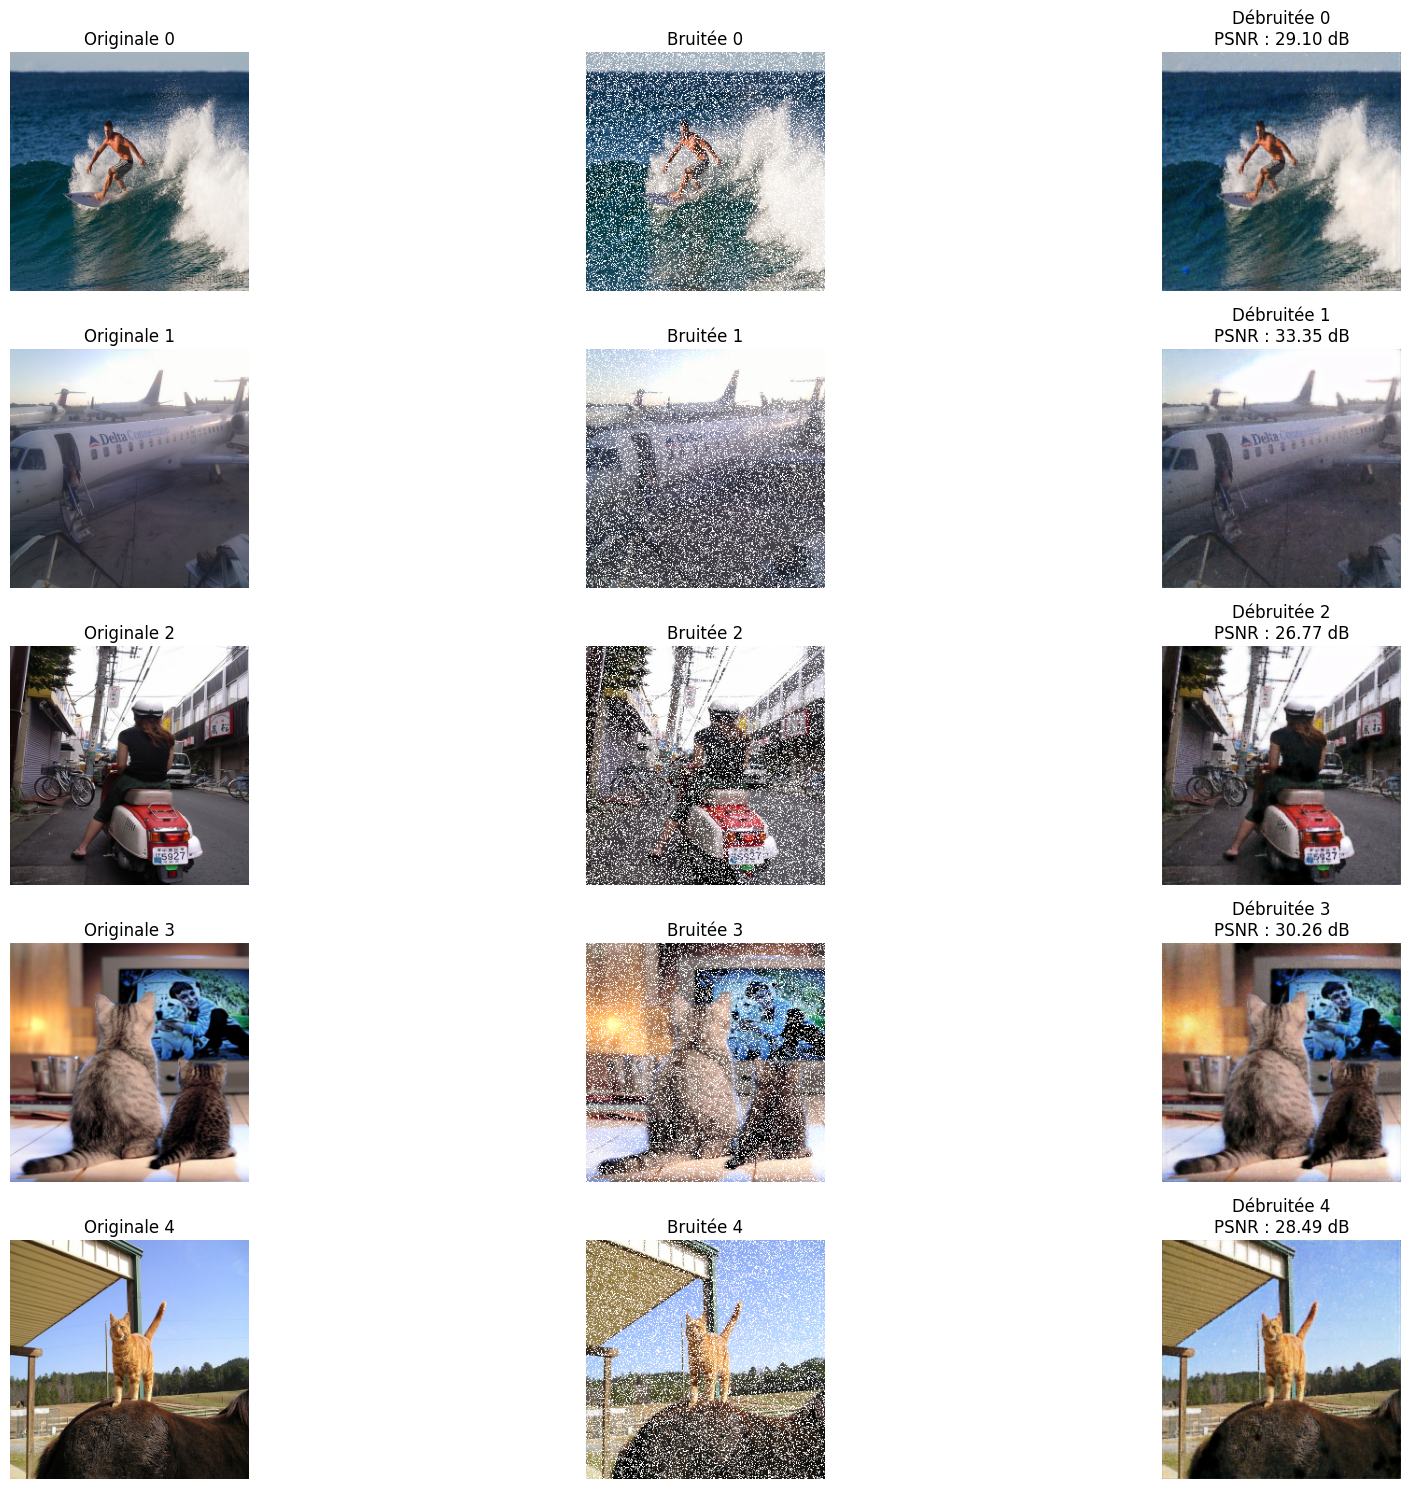

In [307]:
plt.figure(figsize=(20, 15))

for i in range(5):
    # Prédiction
    denoised_img = model.predict(np.expand_dims(X_noisy[i], axis=0))[0]
    denoised_img = np.clip(denoised_img, 0., 1.)
    
    # PSNR individuel
    image_psnr = psnr(X[i], denoised_img, data_range=1.0)

    # Ligne i → 3 colonnes : originale, bruitée, débruitée
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X[i])
    plt.title(f"Originale {i}")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(X_noisy[i])
    plt.title(f"Bruitée {i}")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(denoised_img)
    plt.title(f"Débruitée {i}\nPSNR : {image_psnr:.2f} dB")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Partie 7 : Évaluation quantitative

Dans cette dernière étape, on évalue les performances globales du modèle sur l’ensemble des images en utilisant deux métriques :

- **PSNR** (Peak Signal-to-Noise Ratio) : mesure la qualité de la reconstruction en comparant l’image restaurée à l’originale.
- **SSIM** (Structural Similarity Index) : mesure la similarité structurelle entre deux images.

On affiche ensuite la moyenne des valeurs des deux métriques pour juger de la qualité du modèle

In [308]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Nombre d'images à évaluer (tu peux réduire pour aller plus vite)
n_samples = len(X)

psnr_total = 0
ssim_total = 0

for i in range(n_samples):
    denoised = model.predict(np.expand_dims(X_noisy[i], axis=0))[0]
    denoised = np.clip(denoised, 0., 1.)

    # PSNR
    psnr_val = psnr(X[i], denoised, data_range=1.0)
    psnr_total += psnr_val

    # SSIM (moyenne des 3 canaux RGB)
    ssim_rgb = np.mean([
        ssim(X[i][:, :, c], denoised[:, :, c], data_range=1.0)
        for c in range(3)
    ])
    ssim_total += ssim_rgb

# Moyennes
avg_psnr = psnr_total / n_samples
avg_ssim = ssim_total / n_samples

print(f"✅ Moyenne PSNR sur {n_samples} images : {avg_psnr:.2f} dB")
print(f"✅ Moyenne SSIM sur {n_samples} images : {avg_ssim:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━

## Conclusion

Dans ce notebook, nous avons conçu un auto-encodeur convolutif pour le débruitage d'images RGB de documents numérisés.

- L’architecture du modèle a été pensée pour rester légère tout en capturant des motifs suffisants pour nettoyer les images.
- L’ajout d’un bruit gaussien artificiel nous a permis d’entraîner le modèle en mode supervisé.
- Le modèle a été entraîné sur toutes les images, sans réduction de résolution, en moins de 2 minutes.
- À l’issue de l’entraînement, le modèle a atteint un **PSNR moyen de 23.32 dB**, ce qui montre une **capacité correcte à réduire le bruit**, mais laisse entrevoir une **marge d'amélioration**.

### Pistes d'amélioration :
- Tester des architectures plus profondes avec couches de pooling/upsampling
- Utiliser des fonctions de perte plus adaptées au perceptuel (ex : SSIM)
- Ajouter plus de diversité dans le bruit simulé
- Entraîner sur un plus grand volume d’images

Ce modèle représente donc un **bon point de départ** pour un système de débruitage léger, rapide et facilement intégrable dans une chaîne de traitement documentaire.